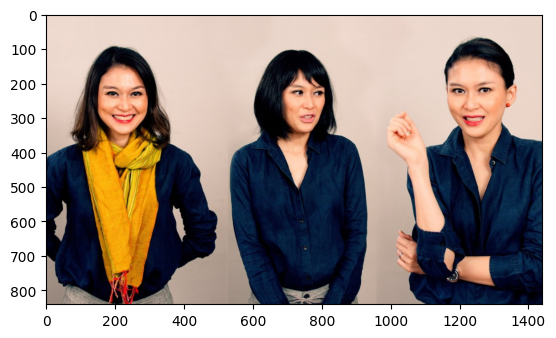

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

IMAGE_PATH = 'images/people/tiga.jpg'

FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.9
THICKNESS = 1

BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)


def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)


def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)


def get_coco_classes(path):
    with open(path, 'rt') as f:
        return f.read().rstrip('\n').split('\n')


img = cv2.imread(IMAGE_PATH)
cv2_imshow(img)

In [117]:
model = 'models/yolo/yolov5n.onnx'
net = cv2.dnn.readNetFromONNX(model)
blob = cv2.dnn.blobFromImage(img, 1/255, (640, 640))
net.setInput(blob)

# 25200 bounding boxes
# every bounding boxes has 85 columns (x, y, w, h, confidence, 80 object classes)
output = net.forward()
print(output.shape)

(1, 25200, 85)


[ 2 12 13]


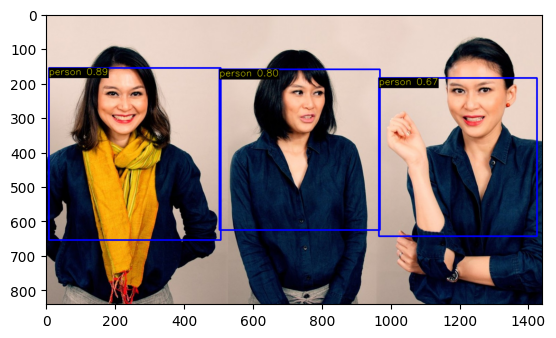

In [118]:
INPUT_WIDTH = INPUT_HEIGHT = 640

CX = 0
CY = 1
W = 2
H = 3
CONFIDENCE = 4


THRESHOLD_CONFIDENCE = 0.40
THRESHOLD_SCORE = 0.45
THRESHOLD_NMS = 0.50

bboxes = output[0]

h, w, _ = img.shape

x_factor = w / INPUT_WIDTH
y_factor = w / INPUT_HEIGHT

class_ids = list()
confidences = list()
selected_bboxes = list()

for bbox in bboxes:
    if bbox[CONFIDENCE] < THRESHOLD_CONFIDENCE:
        continue

    classes_score = bbox[CONFIDENCE+1:]
    class_id = np.argmax(classes_score)

    if classes_score[class_id] < THRESHOLD_SCORE:
        continue

    confidences.append(bbox[CONFIDENCE])
    class_ids.append(class_id)

    cx, cy, w, h = bbox[CX], bbox[CY], bbox[W], bbox[H]
    left = int((cx - w/2) * x_factor)
    top = int((cy - h/2) * y_factor)
    width = int(w * x_factor)
    height = int(h * y_factor)
    box = np.array([left, top, width, height])
    selected_bboxes.append(box)

indices = cv2.dnn.NMSBoxes(selected_bboxes, confidences, THRESHOLD_CONFIDENCE,
                           THRESHOLD_NMS)

BLUE = (255, 0, 0)
THICKNESS = 1

classes = get_coco_classes("models/coco.names")

for i in indices:
    bbox = selected_bboxes[i]
    left, top, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    label = "{} {:.2f}".format(classes[class_ids[i]], round(confidences[i], 2))
    cv2.rectangle(img, (left, top), (left+width, top+width), BLUE, 3*THICKNESS)
    draw_label(img, label, left, top)

cv2_imshow(img)

print(indices)